In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.special import logsumexp
from scipy.optimize import minimize

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from aeons.lm_partial import analytic_lm_params, X_end_formula, analytic_lm, params_from_d
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG
from aeons.endpoint import EndModel

In [2]:
def add_logZ(samples):    
    logw = samples.logw()
    logZ = np.zeros_like(logw)
    logZ[0] = logw.iloc[0]
    for i in range(1, len(samples)):
        logZ[i] = logsumexp([logZ[i-1], logw.iloc[i]])
    samples['logZ'] = logZ
    return samples

def get_dlogZ(logZ):
    logZ = pd.Series(logZ)
    dlogZ = logZ.diff(1)[1:]
    return dlogZ

def get_dlogZ_rolling(dlogZ, N_rolling):
    dlogZ = pd.Series(dlogZ)
    dlogZ_rolling = dlogZ.rolling(N_rolling).mean()
    dlogZ_rolling.dropna(inplace=True)
    return dlogZ_rolling

import numpy.polynomial.polynomial as poly
def fit_dlogZ(dlogZ, deg):
    x = dlogZ.index.get_level_values(0).values
    y = dlogZ.values
    coefs = poly.polyfit(x, y, deg)
    return coefs

In [3]:
class IncrementEndpoint:
    def __init__(self, samples, N_rolling):
        self.samples = add_logZ(samples)
        self.logZ = self.samples['logZ']
        self.dlogZ = get_dlogZ(self.logZ)
        self.dlogZ_rolling = get_dlogZ_rolling(self.dlogZ, N_rolling)
    
    def true_endpoint(self, epsilon=1e-3):
        logZ = self.logZ
        logZ_tot = logZ.iloc[-1]
        logZ_f = np.log(1 - epsilon) + logZ_tot
        index_f = logZ[logZ > logZ_f].index.get_level_values(0)[0]
        return index_f

    def index(self, iteration):
        return self.dlogZ.iloc[iteration:].index.get_level_values(0).values
    
    def dlogZ_fit(self, iteration, N_fit):
        return self.dlogZ_rolling.iloc[iteration-N_fit : iteration]
    
    def pred(self, iteration, N_fit):
        index = self.index(iteration)
        dlogZ_fit = self.dlogZ_fit(iteration, N_fit)
        coefs = fit_dlogZ(dlogZ_fit, 1)
        dlogZ_pred = poly.polyval(index, coefs)
        index_pred = index[dlogZ_pred > 0]
        dlogZ_pred = dlogZ_pred[dlogZ_pred > 0]
        return index_pred, dlogZ_pred

    def plot_pred(self, iteration, N_fit):
        index_pred, dlogZ_pred = self.pred(iteration, N_fit)
        dlogZ_rolling = self.dlogZ_rolling
        dlogZ_fit = self.dlogZ_fit(iteration, N_fit)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        ax1.plot(dlogZ_rolling.index.get_level_values(0), dlogZ_rolling)
        ax1.plot(dlogZ_fit.index.get_level_values(0), dlogZ_fit, color='c')
        ax1.plot(index_pred, dlogZ_pred, color='orange', lw=1)
        ax1.set_ylim(0, dlogZ_rolling.iloc[0])

        ax2.plot(dlogZ_rolling.index.get_level_values(0), dlogZ_rolling)
        ax2.plot(dlogZ_fit.index.get_level_values(0), dlogZ_fit, color='c')
        ax2.plot(index_pred, dlogZ_pred, color='orange', lw=1)
        ax2.axvline(x = iteration, lw=.5, ls='--', color='c')
        ax2.set_xlim(iteration - N_fit, len(self.samples))
        ax2.set_ylim(0, dlogZ_rolling.loc[iteration-N_fit].values)

    def iterations(self, iteration, N_fit, epsilon=1e-3):
        logZ_dead = self.logZ.loc[iteration]
        index_pred, dlogZ_pred = self.pred(iteration, N_fit)
        logZ_live = dlogZ_pred.sum()
        logZ_tot = logZ_dead + logZ_live
        logZ_f = np.log(1 - epsilon) + logZ_tot
        index_f = index_pred[np.argmax([logZ_dead + dlogZ_pred.cumsum() > logZ_f])]
        return logZ_dead, logZ_tot, index_f

### Gaussian chain

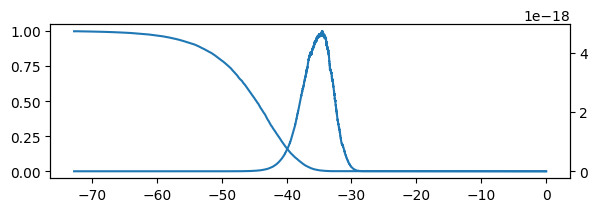

In [4]:
from aeons.toy_samples import gaussian_samples, correlated_gaussian_samples
nlive = 500
d, sigma = 10, 0.01
samples = gaussian_samples(nlive, d, sigma)
gauss = EndModel(samples)
gauss.plot_lx()

In [5]:
samples = gauss.samples
increment = IncrementEndpoint(samples, N_rolling=1000)
true_end = increment.true_endpoint()

In [6]:
iterations = np.linspace(100, 30000, 10).astype(int)
logXfs, logXfs_std = gauss.logXfs(iterations, Nset=10)

(0.0, 35000.0)

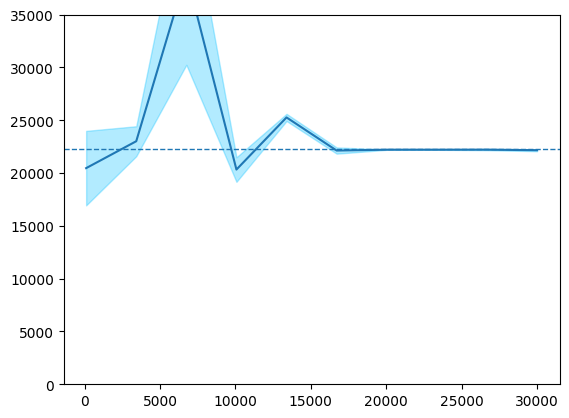

In [7]:
predictions, predictions_std = logXfs * -500, logXfs_std * -500
plt.plot(iterations, predictions)
plt.fill_between(iterations, predictions - predictions_std, predictions + predictions_std, color='deepskyblue', alpha=0.3)
plt.axhline(y=true_end, lw=1, ls='--')
plt.ylim(0, 35000)

(-2215.157704111345, -115.6168270895464, 6196)

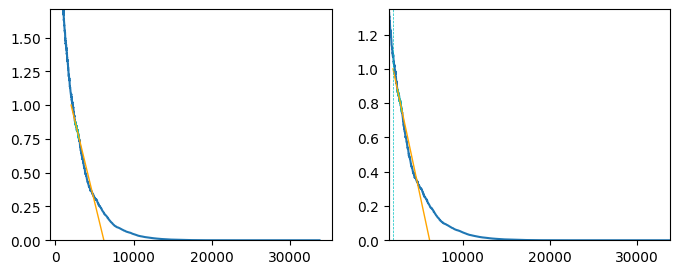

In [8]:
iteration = 2000
N_fit = 500
increment.plot_pred(iteration, N_fit)
increment.iterations(iteration, N_fit)

(0.0, 26704.8)

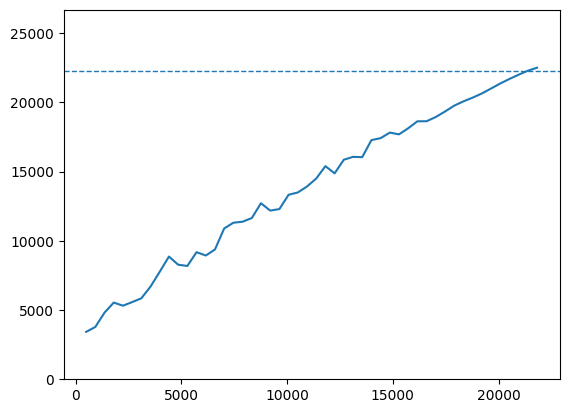

In [9]:
N = 50
iterations = np.linspace(N_fit, true_end, N, endpoint=False).astype(int)
predictions = np.zeros(N)
for i, iteration in enumerate(iterations):
    predictions[i] = increment.iterations(iteration, N_fit)[-1]
plt.plot(iterations, predictions)
plt.axhline(y=true_end, lw=1, ls='--')
plt.ylim(0, true_end*1.2)

### Wedding cake chain